# Diffusion Model на MNIST

В этом ноутбуке мы реализуем и обучим диффузионную модель (DDPM - Denoising Diffusion Probabilistic Model) для генерации изображений цифр из датасета MNIST.

**Diffusion Model** работает в два этапа:
- **Forward process (Прямой процесс)** - постепенное добавление гауссовского шума к изображению
- **Reverse process (Обратный процесс)** - обучение нейронной сети предсказывать и удалять шум, чтобы восстановить исходное изображение

Модель обучается предсказывать шум, который был добавлен на каждом шаге диффузии.


## Импорты


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

## Загрузка и визуализация датасета MNIST

Сначала загрузим датасет MNIST и посмотрим на примеры изображений.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)


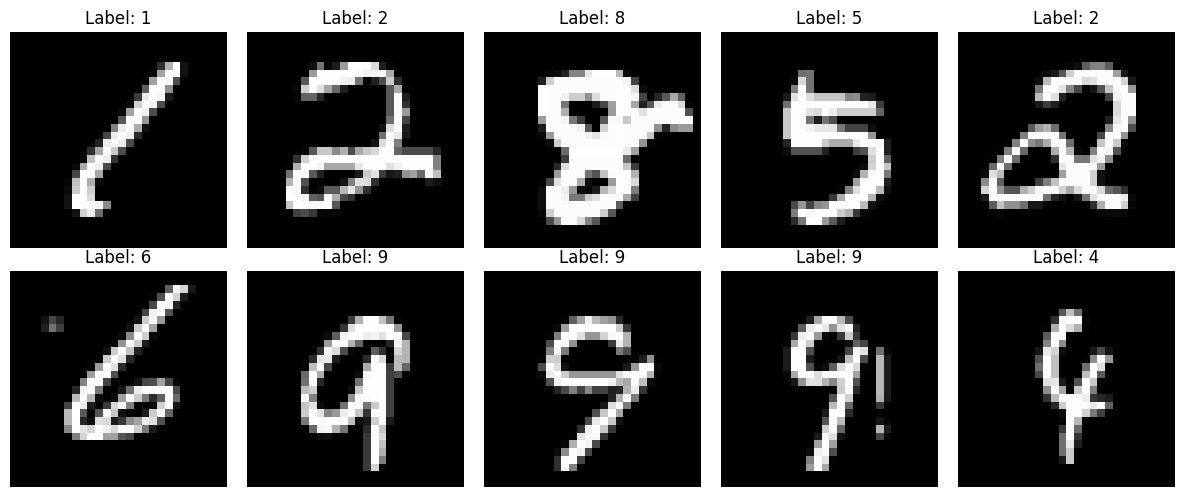

In [3]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Архитектура U-Net для предсказания шума

Используем упрощенную U-Net архитектуру для предсказания шума. U-Net состоит из encoder (сжатие) и decoder (расширение) с skip connections.


In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        h = h + time_emb[:, :, None, None]
        h = self.bnorm2(self.relu(self.conv2(h)))
        return h

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.upsample = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        h = h + time_emb[:, :, None, None]
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.upsample(h)

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        time_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )
        
        self.down1 = Block(1, 64, time_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = Block(64, 128, time_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.bot1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bot2 = nn.Conv2d(256, 256, 3, padding=1)
        self.up1 = UpBlock(256, 128, time_dim)
        self.up2 = UpBlock(128, 64, time_dim)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x1 = self.down1(x, t)
        x1_pooled = self.pool1(x1)
        x2 = self.down2(x1_pooled, t)
        x2_pooled = self.pool2(x2)
        x2 = F.relu(self.bot1(x2_pooled))
        x2 = F.relu(self.bot2(x2))
        x = self.up1(x2, t)
        x = self.up2(x, t)
        return self.out(x)


In [5]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size

        self.beta = self.prepare_noise_schedule()
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, device):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(device)
            self.alpha_hat = self.alpha_hat.to(device)
            self.alpha = self.alpha.to(device)
            self.beta = self.beta.to(device)
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(n) * i).long().to(device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((beta) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x


In [6]:
class DiffusionModel(pl.LightningModule):
    def __init__(self, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = SimpleUNet()
        self.diffusion = Diffusion(noise_steps=1000, img_size=28)
        self.lr = lr
        
    def forward(self, x, t):
        return self.model(x, t)
    
    def training_step(self, batch, batch_idx):
        images, _ = batch
        images = images * 2.0 - 1.0
        
        t = self.diffusion.sample_timesteps(images.shape[0]).to(self.device)
        self.diffusion.alpha_hat = self.diffusion.alpha_hat.to(self.device)
        x_t, noise = self.diffusion.noise_images(images, t)
        predicted_noise = self.model(x_t, t)
        loss = F.mse_loss(noise, predicted_noise)
        
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
    
    def on_train_epoch_end(self):
        save_dir = 'generated_images'
        os.makedirs(save_dir, exist_ok=True)
        
        sampled_images = self.diffusion.sample(self.model, n=64, device=self.device)
        
        fig, axes = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(64):
            ax = axes[i // 8, i % 8]
            img = sampled_images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'diffusion_epoch_{self.current_epoch:03d}.png'))
        plt.close()
        
        if self.logger:
            grid = utils.make_grid(sampled_images.float() / 255.0, nrow=8, normalize=True)
            self.logger.experiment.add_image('generated_images', grid, self.current_epoch)


## Обучение модели

Обучаем диффузионную модель на датасете MNIST. Используем callback для сохранения лучших чекпоинтов.


In [7]:
model = DiffusionModel(lr=3e-4)

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    save_top_k=1,
    filename='diffusion-mnist-{epoch:02d}-{train_loss:.4f}'
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True
)

trainer.fit(model, train_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | SimpleUNet | 2.0 M  | train
---------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.163     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=50` reached.


## Визуализация результатов

Генерируем изображения с помощью обученной диффузионной модели и визуализируем результаты.


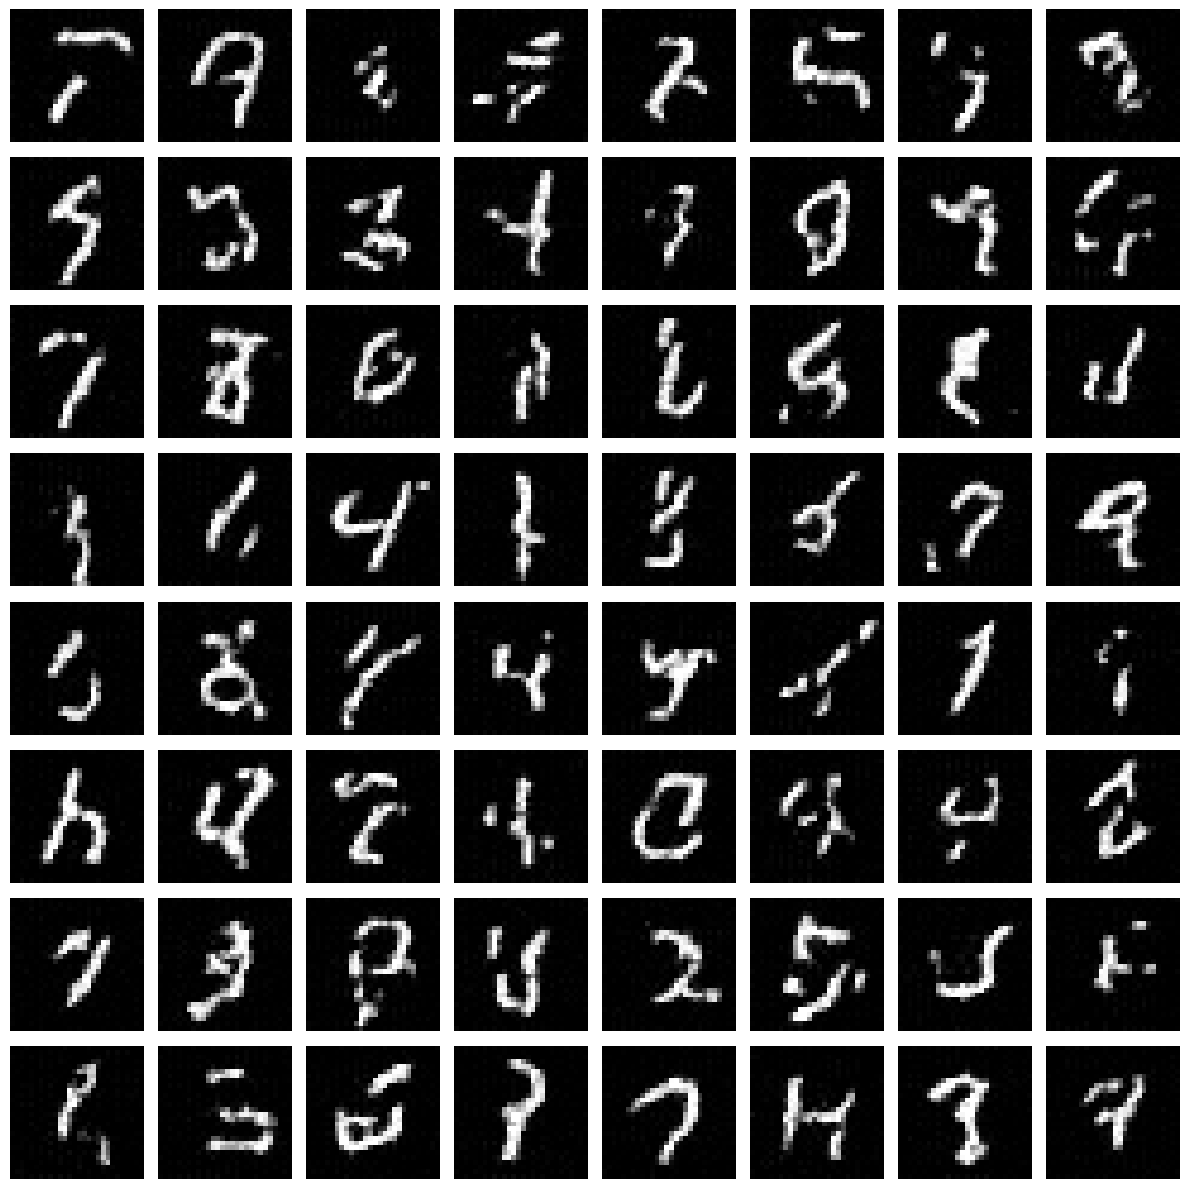

In [15]:
model.eval()
sampled_images = model.diffusion.sample(model.model, n=64, device=model.device)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(64):
    ax = axes[i // 8, i % 8]
    img = sampled_images[i].squeeze().cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
